# Import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# What is Convolution Layers?

## Why do we need to use it?

ANN doesn't translate well into working with higher dimensions of data  
 - The higher the dimension of input data, the more neurons we need in each layer, hence resulting in overfitting.  
 - The ANN processes each pixel separately, causing a loss of positional context when used with structured data like images.

Imagine if we have a picture of a handwritten 5 in a 28 × 28 resolution

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 33.1MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 89.8MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.57MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



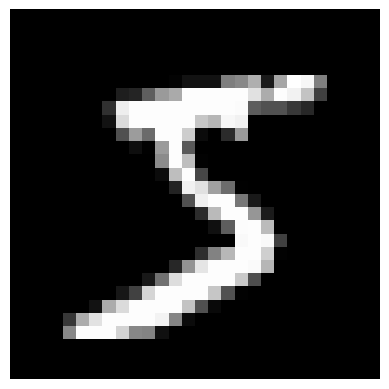

(28, 28)


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

for image, label in mnist_dataset:
    if label == 5:
        num = image.squeeze().numpy()
        break

plt.imshow(num, cmap="gray")
plt.axis("off")
plt.show()
print(num.shape)

We would need 28 × 28 = 784 neurons in the first layer to process this image. While we could downscale the resolution to a smaller size, some data will always be lost in the process.

In [ ]:
print(num)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

And there's also useless information in the picture, like the background, which does not need computing. If we don't handle it correctly, it will become noise in the output, making the model less efficient and potentially leading to incorrect predictions.

## Convolutional Process




The convolutional layer is designed to fix that problem. It slides a **kernel** across the data plane to extract important information while reducing unnecessary information. This helps focus on meaningful patterns, such as edges and shapes, while ignoring irrelevant details like background noise.

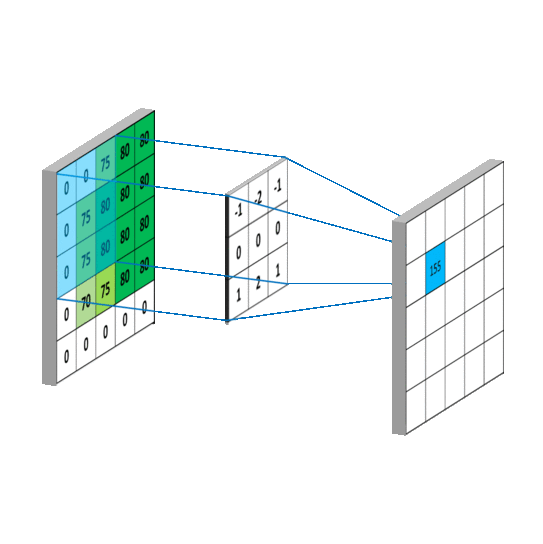

We call these layers **Convolutional Layers**, and they have several important attributes:

- The **kernel** is a small matrix that slides across the input data. At each position, it performs **element-wise multiplication** with the input values and then sums them up to produce a **single number** in the output feature map.
- Each kernel is designed to detect **one specific type of feature**, such as **edges, textures, or patterns**.
- Since a single kernel can only extract **one type of feature**, we typically use **multiple kernels** in one convolutional layer.
- Each kernel operates on the input separately, producing its own output. These outputs are stacked together into **channels**.  
  - For example, if we use **5 kernels**, we get **5 output channels**.
  - The input image is **copied across all channels**, so every kernel processes the same input independently.
- As a result, the output of a convolutional layer is not just **one feature map**, but a **stack of feature maps**, capturing multiple aspects of the image.
- **Stride** is the distance the kernel moves after each operation.  
  - A **larger stride** skips more pixels, causing the output to have a **smaller dimension** because fewer positions are computed.  
  - A **larger stride** also leads to **diluted data**, meaning some fine details in the input might be lost because fewer computations are performed.  
  - A **smaller stride** keeps more details but increases computational cost.  

- **Padding** is a layer of **zeros** added around the edges of the input.  
  - It helps the kernel **capture features near the edges** of the image, which would otherwise be lost.  
  - Without padding, the output size **shrinks** after each convolution, reducing spatial information.  

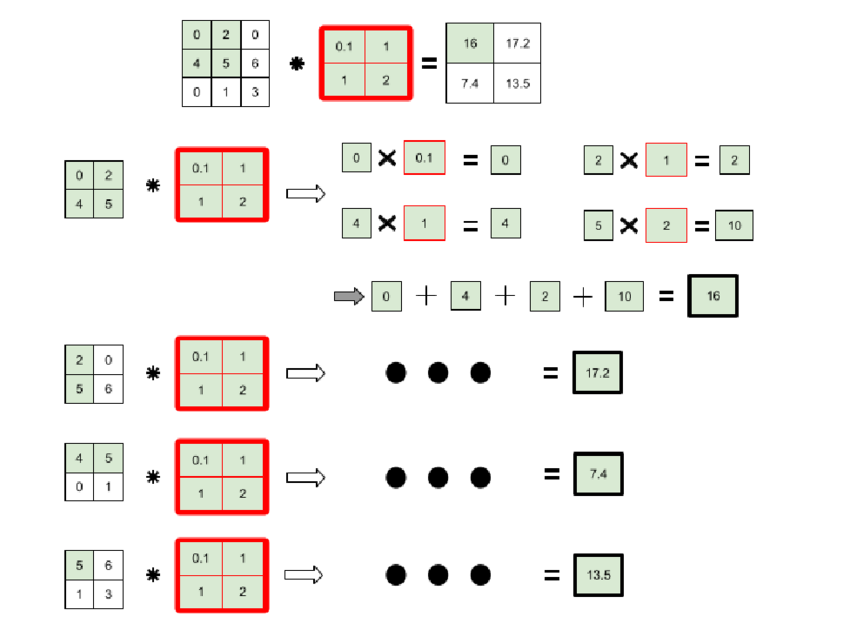

In [ ]:
class ConvolutionLayer:
    def __init__(self, kernel_size=3, stride=1, padding=0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.kernel = np.random.randn(kernel_size, kernel_size)

    def pad_input(self, input_array):
        if self.padding > 0:
            return np.pad(input_array, ((self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        return input_array

    def convolve(self, input_array):
        input_padded = self.pad_input(input_array)

        input_size = input_padded.shape[0]
        output_size = (input_size - self.kernel_size) // self.stride + 1

        output = np.zeros((output_size, output_size))

        for i in range(0, output_size):
            for j in range(0, output_size):
                x_start = i * self.stride
                x_end = x_start + self.kernel_size
                y_start = j * self.stride
                y_end = y_start + self.kernel_size

                region = input_padded[x_start:x_end, y_start:y_end]
                output[i, j] = np.sum(region * self.kernel)

        return output

In [ ]:
c = ConvolutionLayer(4, 2, 0)

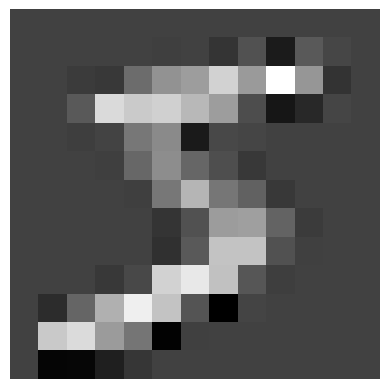

(13, 13)


In [ ]:
convo_num = c.convolve(num)
plt.imshow(convo_num, cmap="gray")
plt.axis("off")
plt.show()
print(convo_num.shape)

In this case, we are using only one feature map. Now, we will use multiple feature maps to extract different features from the image.

In [ ]:
class ConvolutionLayer:
    def __init__(self, kernel_size=3, num_kernels=3, stride=1, padding=0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_kernels = num_kernels

        self.kernels = np.random.randn(num_kernels, kernel_size, kernel_size)

    def pad_input(self, input_array):
        if self.padding > 0:
            return np.pad(input_array, ((self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        return input_array

    def convolve(self, input_array):
        input_padded = self.pad_input(input_array)

        input_size = input_padded.shape[0]
        output_size = (input_size - self.kernel_size) // self.stride + 1

        output = np.zeros((self.num_kernels, output_size, output_size))

        for k in range(self.num_kernels):
            kernel = self.kernels[k]
            for i in range(0, output_size):
                for j in range(0, output_size):
                    x_start = i * self.stride
                    x_end = x_start + self.kernel_size
                    y_start = j * self.stride
                    y_end = y_start + self.kernel_size

                    region = input_padded[x_start:x_end, y_start:y_end]
                    output[k, i, j] = np.sum(region * kernel)

        return output

In [ ]:
c = ConvolutionLayer(4, 3, 2, 0)

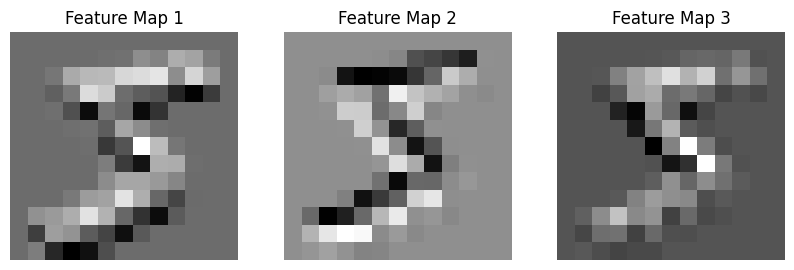

Output feature map shape: (3, 13, 13)


In [ ]:
output_feature_maps = c.convolve(num)
fig, axes = plt.subplots(1, output_feature_maps.shape[0], figsize=(10, 4))
for idx, feature_map in enumerate(output_feature_maps):
    axes[idx].imshow(feature_map, cmap="gray", interpolation="nearest")
    axes[idx].axis("off")
    axes[idx].set_title(f"Feature Map {idx+1}")

plt.show()

print("Output feature map shape:", output_feature_maps.shape)

We observe that each kernel produces a different result with the same input image. We use this behavior to capture various features present in the image.

After that, we have a pooling layer, which can downsample without using parameters. This potentially reduces computation while also helping the model generalize better and prevent overfitting.

In [ ]:
class PoolingLayer:
    def __init__(self, pool_size=2, stride=2, mode="max"):
        self.pool_size = pool_size
        self.stride = stride
        self.mode = mode

    def pool(self, input_array):
        input_size = input_array.shape[0]
        output_size = (input_size - self.pool_size) // self.stride + 1
        output = np.zeros((output_size, output_size))

        for i in range(0, output_size):
            for j in range(0, output_size):
                x_start = i * self.stride
                x_end = x_start + self.pool_size
                y_start = j * self.stride
                y_end = y_start + self.pool_size

                region = input_array[x_start:x_end, y_start:y_end]

                if self.mode == "max":
                    output[i, j] = np.max(region)
                elif self.mode == "avg":
                    output[i, j] = np.mean(region)

        return output

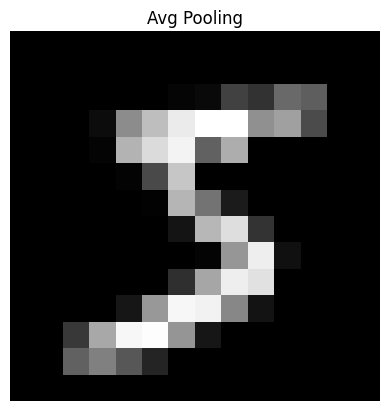

(14, 14)


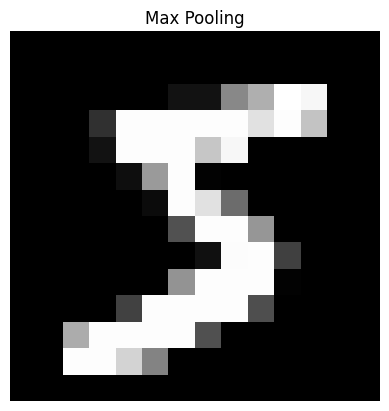

(14, 14)


In [ ]:
avg_pool, max_pool =  PoolingLayer(2, 2, "avg"), PoolingLayer(2, 2, "max")
output_avg, output_max = avg_pool.pool(num), max_pool.pool(num)
plt.imshow(output_avg, cmap="gray")
plt.axis("off")
plt.title("Avg Pooling")
plt.show()

print(output_avg.shape)

plt.imshow(output_max, cmap="gray")
plt.axis("off")
plt.title("Max Pooling")
plt.show()

print(output_max.shape)

-----
Conv layer & pooling layer from PyTorch

torch.Size([1, 1, 28, 28])
Convoluted tensor shape: torch.Size([1, 3, 13, 13])


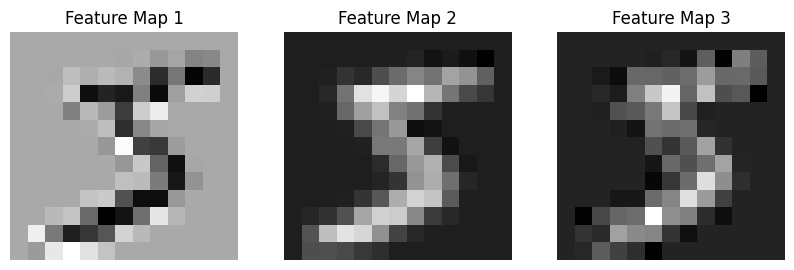

Non-Conv Pooled tensor shape: torch.Size([1, 1, 14, 14])


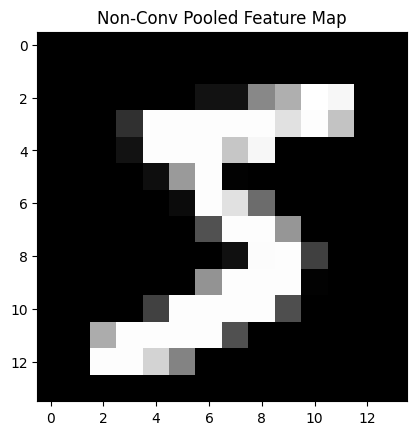

Post-Conv Pooled tensor shape: torch.Size([1, 3, 6, 6])


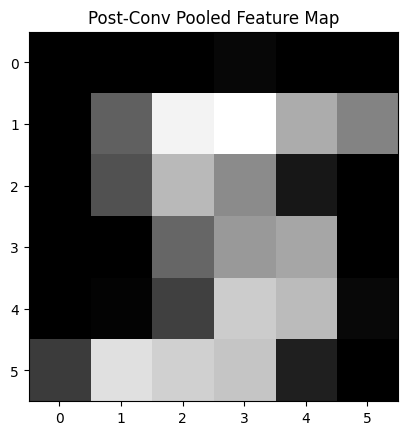

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#----------------Define layer function ------------------
pool_type = 'maxpool'
in_channels, out_channels, kernel_conv_size, stride_conv, padding_conv = 1, 3, 4, 2, 0
kernel_pool_size, stride_pool = 2, 2
#--------------------------------------------------------

# Assuming 'num' is a NumPy array representing your image data
# Convert the NumPy array to a PyTorch tensor
num_tensor = torch.from_numpy(num).float().unsqueeze(0).unsqueeze(0) # Add batch and channel dimensions
print(num_tensor.shape)

# Define the convolutional layer
conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_conv_size, stride=stride_conv, padding=padding_conv)

# Perform convolution
convo_num_tensor = conv_layer(num_tensor)

# Define the pooling layer
if pool_type == 'maxpool':
  pool_layer = nn.MaxPool2d(kernel_size=kernel_pool_size, stride=stride_pool)
else:
  pool_layer = nn.AvgPool2d(kernel_size=kernel_pool_size, stride=stride_pool)

# Perform pooling
pooled_num_tensor = pool_layer(convo_num_tensor)
non_conv_pooled_num_tensor = pool_layer(num_tensor)


# Convert back to NumPy arrays for plotting (if needed)
convo_num_np = convo_num_tensor.squeeze(0).detach().numpy()
pooled_num_np = pooled_num_tensor.squeeze(0).detach().numpy()
non_conv_pooled_num_np = non_conv_pooled_num_tensor.squeeze(0).detach().numpy()


# Plotting (optional):
import matplotlib.pyplot as plt

print("Convoluted tensor shape:", convo_num_tensor.shape)
fig, axes = plt.subplots(1, convo_num_np.shape[0], figsize=(10, 4))
for idx, feature_map in enumerate(convo_num_np):
    axes[idx].imshow(feature_map, cmap="gray", interpolation="nearest")
    axes[idx].axis("off")
    axes[idx].set_title(f"Feature Map {idx+1}")
plt.show()

print("Non-Conv Pooled tensor shape:", non_conv_pooled_num_tensor.shape)
plt.imshow(non_conv_pooled_num_np[0], cmap='gray') # Plot the first feature map of the pooled output
plt.title('Non-Conv Pooled Feature Map')
plt.show()

print("Post-Conv Pooled tensor shape:", pooled_num_tensor.shape)
plt.imshow(pooled_num_np[1], cmap='gray') # Plot the first feature map of the pooled output
plt.title('Post-Conv Pooled Feature Map')
plt.show()
